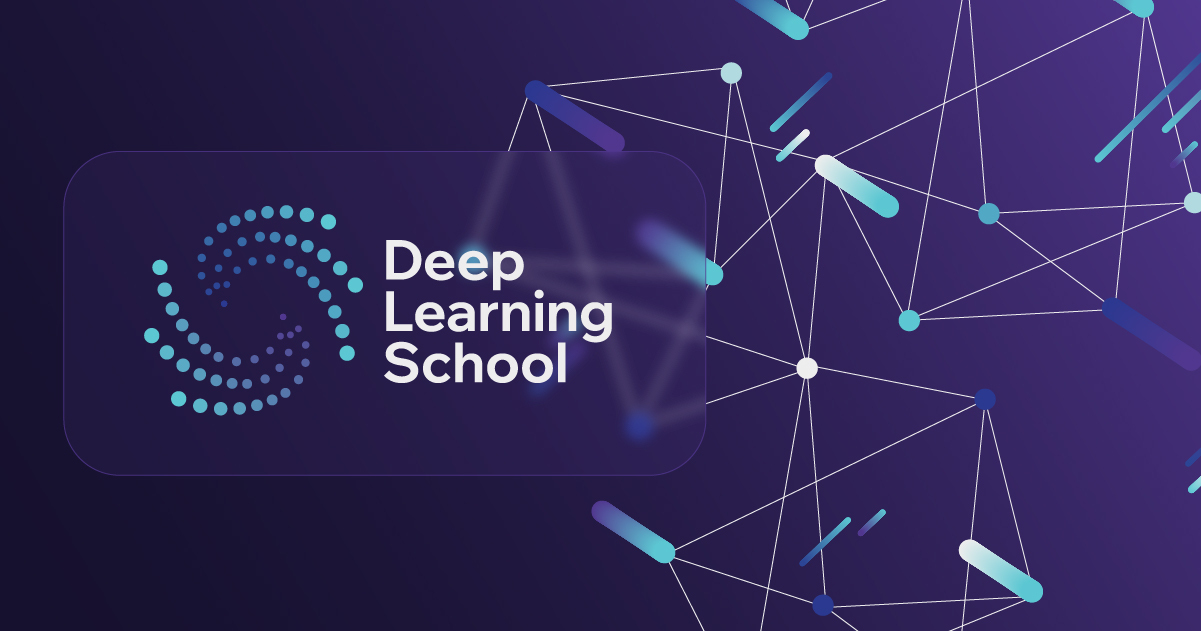


# Домашнее задание "Варианционные автоэнкодеры"

В этом домашнем задании вам предстоит реализовать несколько версий автоэнкодера для работы с изображениями.

Вы научитесь добавлять улыбку на фотографии людей, изменяя их исходное выражение лица с помощью обученной модели. А также, обучите ваш автоэнкодер генерировать изображения рукописных цифр.

In [63]:
!pip install nbstripout
!nbstripout --install

fatal: --local can only be used inside a git repository
Installation failed: not a git repository!


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


Перед тем, как начинать работу с моделями нужно подготовить данные.

In [4]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize

import imageio
from PIL import Image
import kagglehub

%matplotlib inline

In [5]:
from tqdm.notebook import tqdm

В этом задании вам предстоить работать с датасетом [LFW (Labeled Faces in the Wild)](https://datasets.activeloop.ai/docs/ml/datasets/lfw-dataset/#:~:text=What%20is%20LFW%20Dataset%3F,commercial%20algorithms%20prior%20to%20release).

In [2]:
# Скачиваем картинки
images_path = kagglehub.dataset_download("jessicali9530/lfw-dataset")
print("Path to dataset files:", images_path)

Path to dataset files: /kaggle/input/lfw-dataset


In [3]:
# Скачиваем атрибуты
attrs_path = kagglehub.dataset_download("averkij/lfw-attributes")
print("Path to dataset files:", attrs_path)

Path to dataset files: /kaggle/input/lfw-attributes


In [4]:
DATASET_PATH ="/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/"
ATTRIBUTES_PATH = "/kaggle/input/lfw-attributes/lfw_attributes.txt"

In [5]:
def fetch_dataset(dx=80, dy=80, dimx=45, dimy=45):

    df_attrs = pd.read_csv(ATTRIBUTES_PATH, sep='\t', skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns = df_attrs.columns[1:])

    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath, fname)
                photo_id = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person': person_id, 'imagenum': photo_number, 'photo_path': fpath})


    photo_ids = pd.DataFrame(photo_ids)
    df = pd.merge(df_attrs,photo_ids,on=('person', 'imagenum'))

    assert len(df) == len(df_attrs), "Потеряны данные при объединении датафреймов!"

    images = df['photo_path'].apply(imageio.imread)\
                                .apply(lambda img:img[dy:-dy, dx:-dx])\
                                .apply(lambda img: np.array(Image.fromarray(img).resize([dimx, dimy])) )

    images = np.stack(images.values).astype('uint8')
    attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return images, attrs

In [6]:
# Обратите внимание, что датасет представляет собой не только картинки, но и атрибуты
# Атрибуты понадобятся в конце этого задания

images, attrs = fetch_dataset()


Разбейте датасет изображений и атрибутов на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [7]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

In [8]:
print(images.dtype)

uint8


In [11]:
# Нормализуем изображения, также приводим к float32
images_tensor = torch.tensor(images / 255.0, dtype=torch.float32).permute(0, 3, 1, 2)

# Приводим атрибуты к float32
attrs_tensor = torch.tensor(attrs.values.astype(np.float32))

# Разделим на train, val
x_train, x_val, y_train, y_val = train_test_split(
    images_tensor, attrs_tensor, test_size=0.9, shuffle = False)

# Создаем датасет
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

# Упаковываем в dataloader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)

Визуализируем несколько картинок

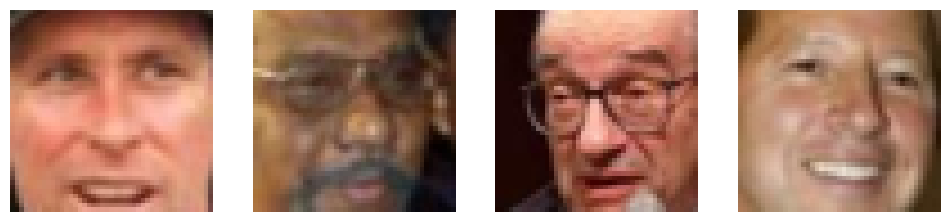

In [12]:
def show_image(batch):
  images = batch[0] # Берем только картинки
  fig, axs = plt.subplots(1, len(images), figsize=(12, 3))
  for i in range(len(images)):
    axs[i].imshow(images[i].permute(1, 2, 0))
    axs[i].axis('off')
  plt.show()

for batch in train_loader:
  show_image(batch)
  break


## 1.2. Архитектура модели (2 балла)
В этом разделе вы напишите и обучите обычный автоэнкодер.



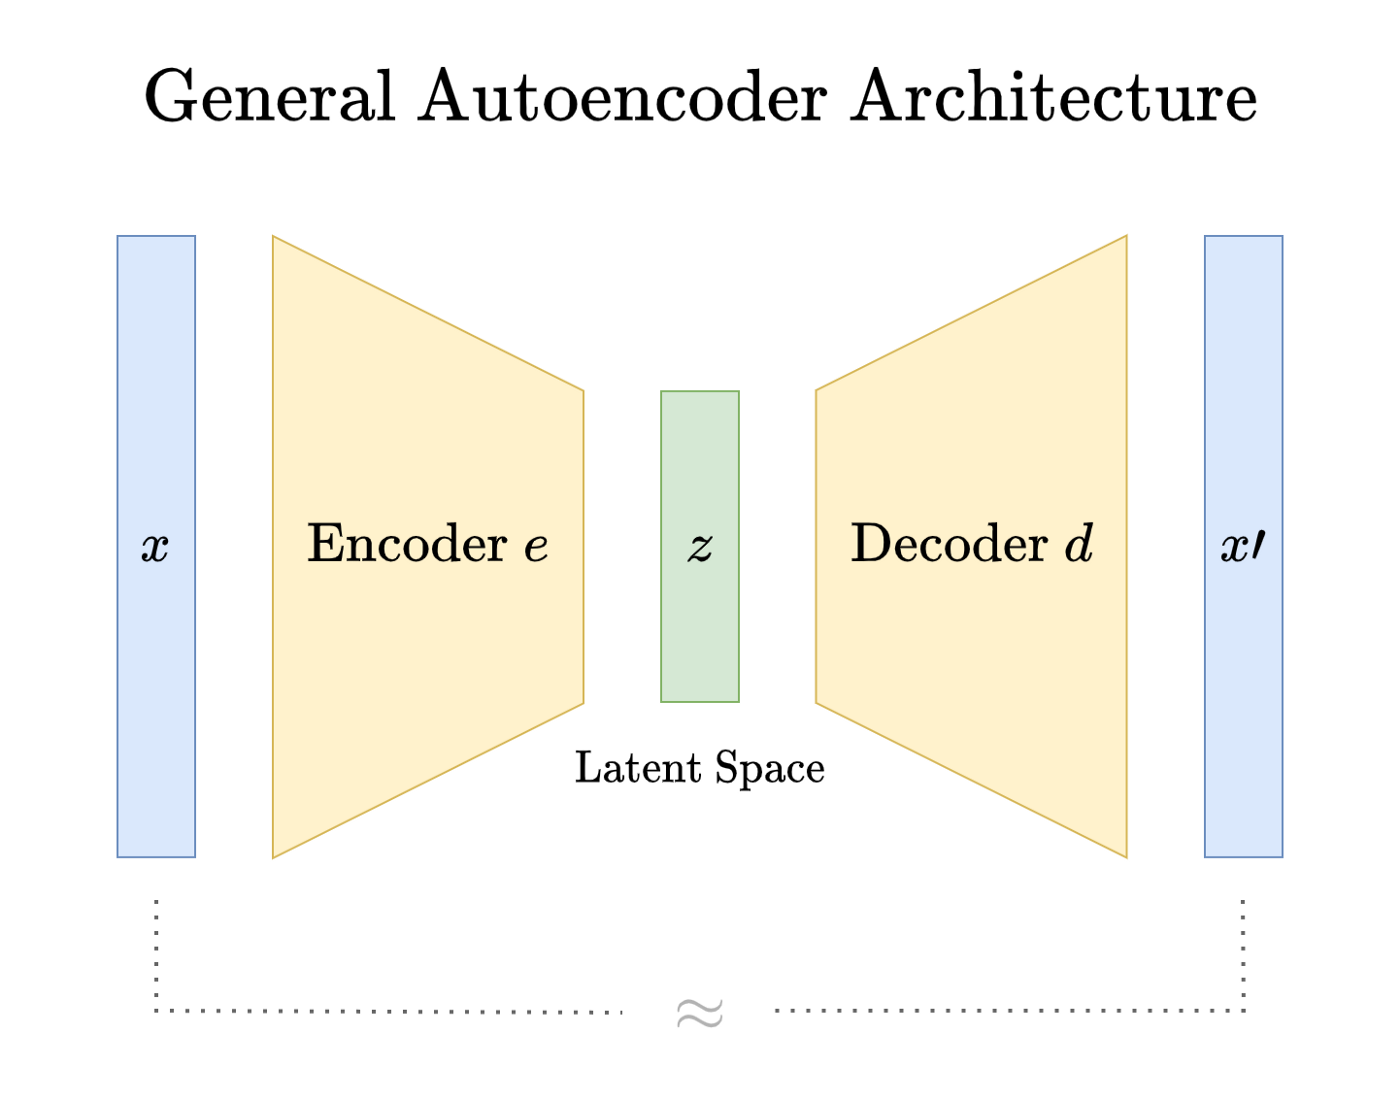

In [13]:
dim_code = 128

In [26]:
sample = next(iter(train_loader))[0]
print(sample.shape)

torch.Size([4, 3, 45, 45])


Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [42]:
class Autoencoder(nn.Module):
    def __init__(self):
       super().__init__()
       self.encoder = nn.Sequential(
           nn.Conv2d(3, 32, kernel_size = 3, stride = 2, padding = 1), # (3, 45, 45) → (32, 23, 23)
           nn.ReLU(),
           nn.Conv2d(32, 64, kernel_size = 3, stride = 2, padding = 1), # (32, 23, 23) → (64, 12, 12)
           nn.ReLU(),
           nn.Flatten(),
           nn.Linear(64 * 12* 12, dim_code),
       )

       self.decoder = nn.Sequential(
           nn.Linear(dim_code, 64 * 12 * 12),
           nn.Unflatten(1, (64, 12, 12)),
           nn.ConvTranspose2d(64, 32, kernel_size = 4, stride = 2, padding = 1),
           nn.ReLU(),
           nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1),
           nn.ReLU(),
           nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1),
           nn.Sigmoid(),
       )

    def forward(self, x):

        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        reconstruction = reconstruction[:, :, :45, :45]
        return reconstruction, latent_code

In [40]:
criterion = F.mse_loss

autoencoder = Autoencoder()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэнкодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

<ipython-input-47-8648d47dcf81>:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30 | Train Loss: 0.0177 | Val Loss: 0.0097


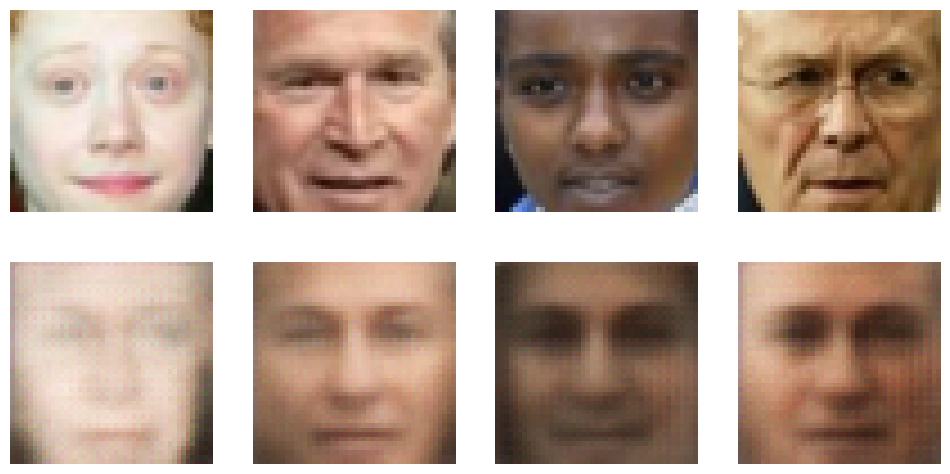

Epoch 2/30 | Train Loss: 0.0086 | Val Loss: 0.0076


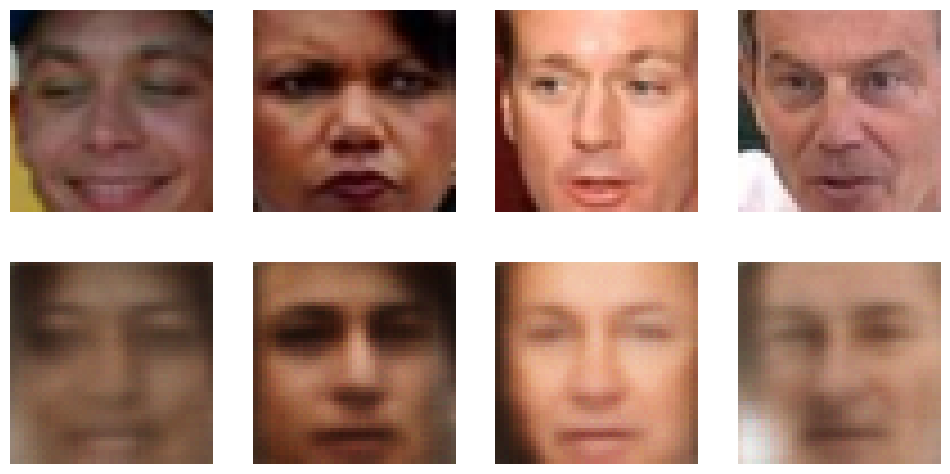

Epoch 3/30 | Train Loss: 0.0071 | Val Loss: 0.0065


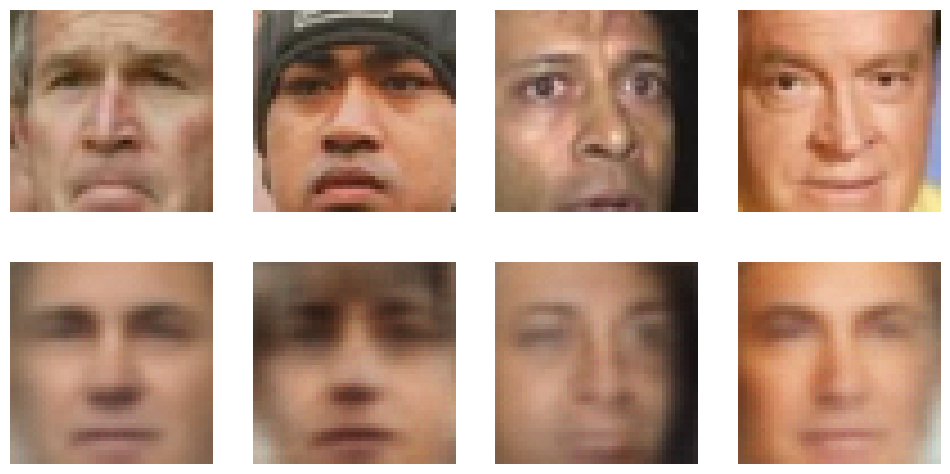

Epoch 4/30 | Train Loss: 0.0061 | Val Loss: 0.0059


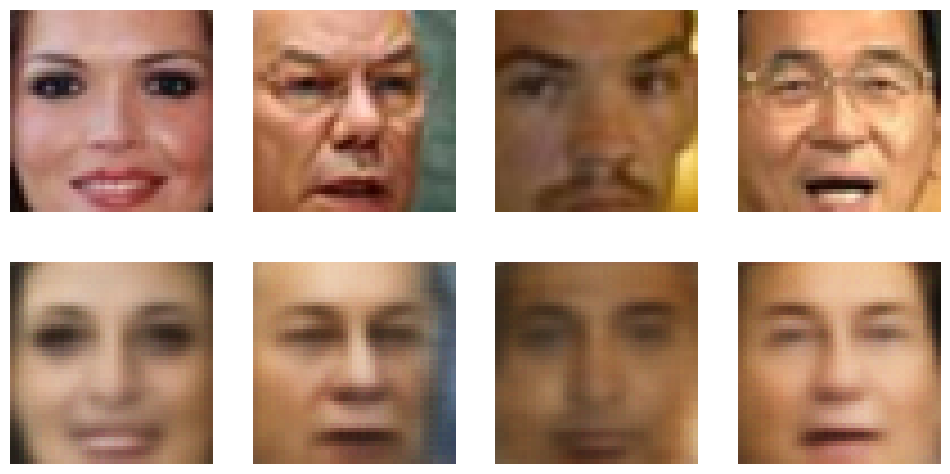

Epoch 5/30 | Train Loss: 0.0052 | Val Loss: 0.0054


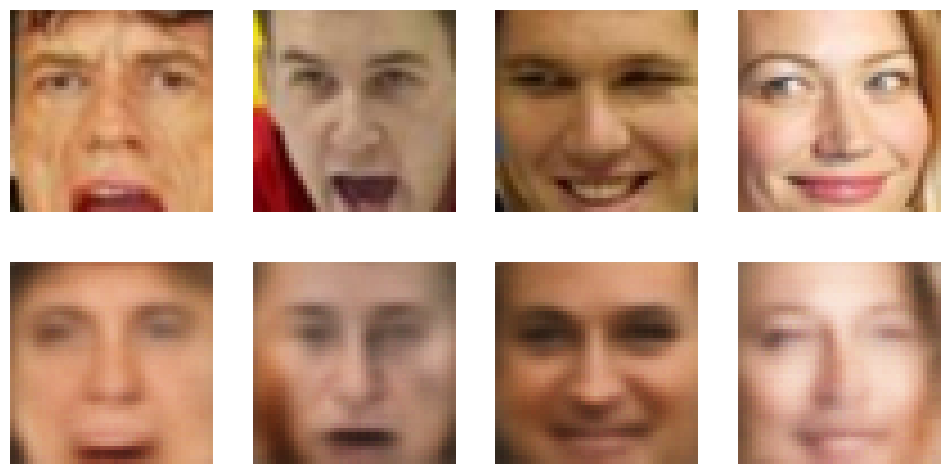

Epoch 6/30 | Train Loss: 0.0051 | Val Loss: 0.0048


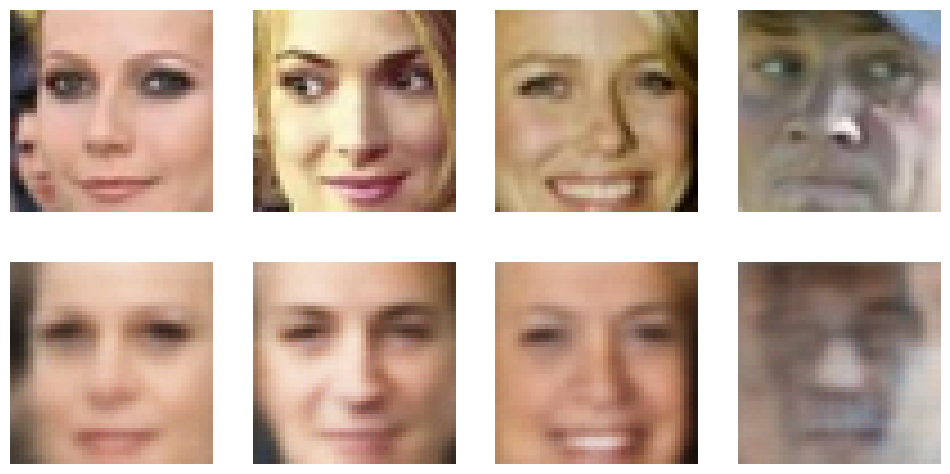

Epoch 7/30 | Train Loss: 0.0042 | Val Loss: 0.0046


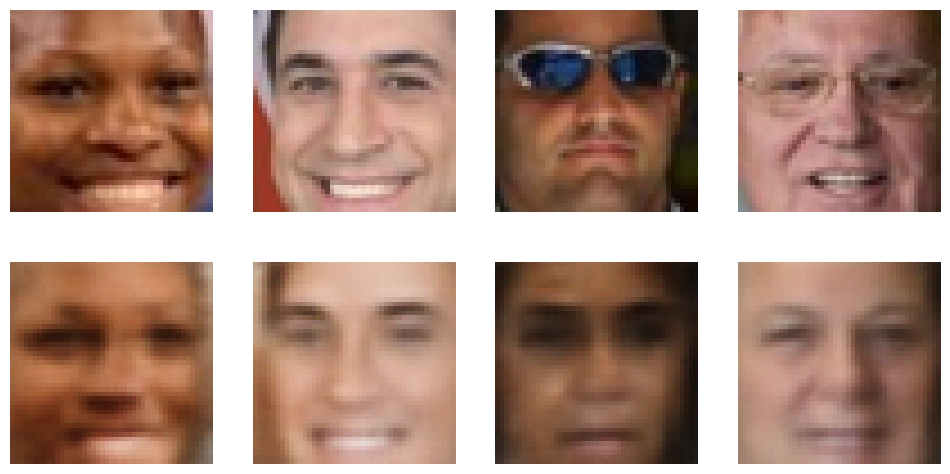

Epoch 8/30 | Train Loss: 0.0039 | Val Loss: 0.0046


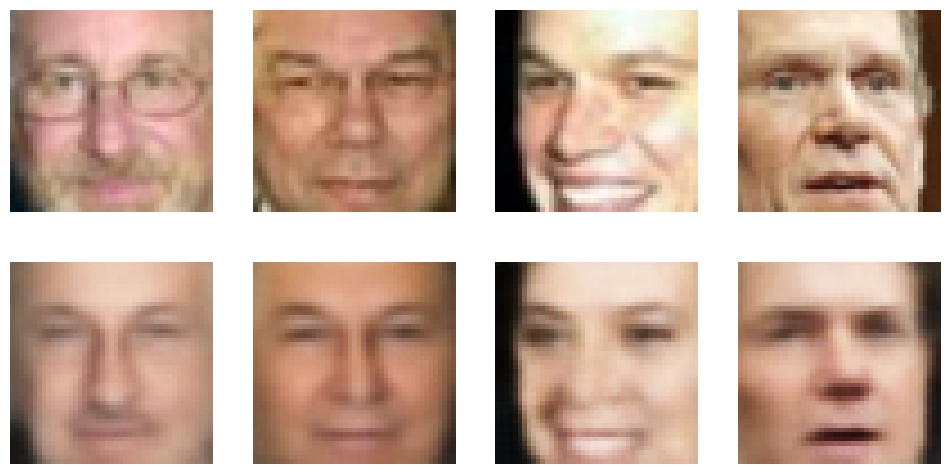

Epoch 9/30 | Train Loss: 0.0035 | Val Loss: 0.0043


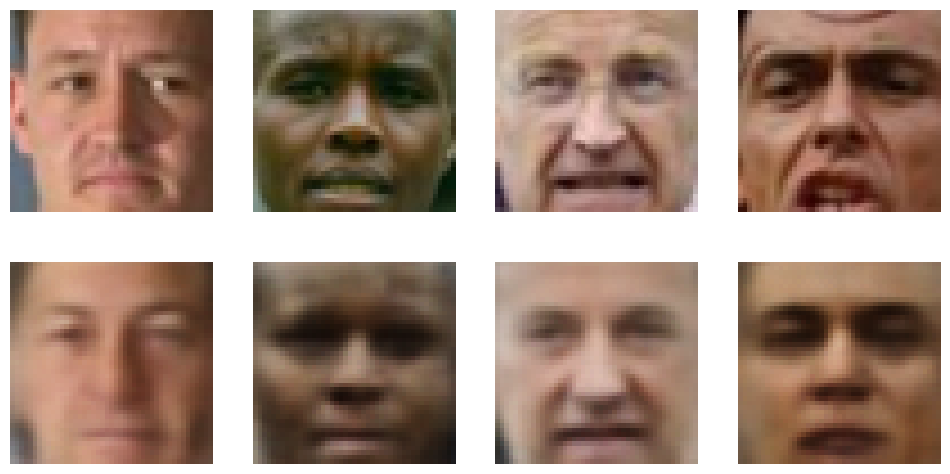

Epoch 10/30 | Train Loss: 0.0033 | Val Loss: 0.0042


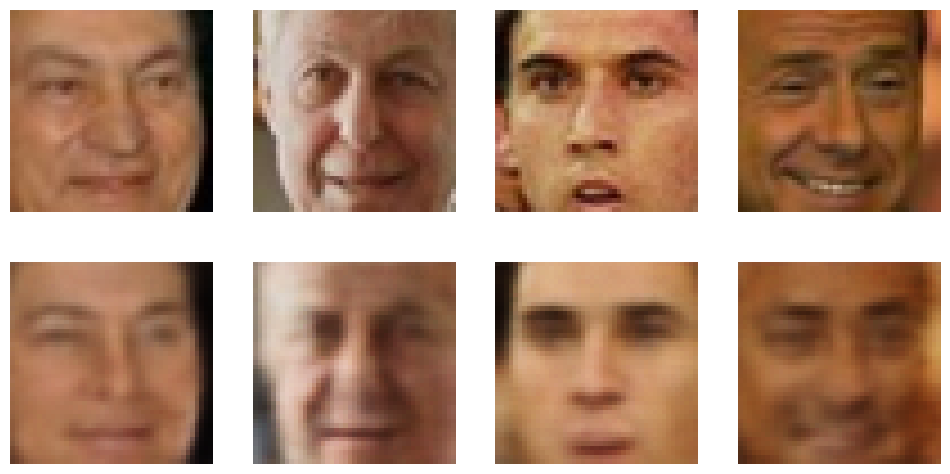

Epoch 11/30 | Train Loss: 0.0034 | Val Loss: 0.0039


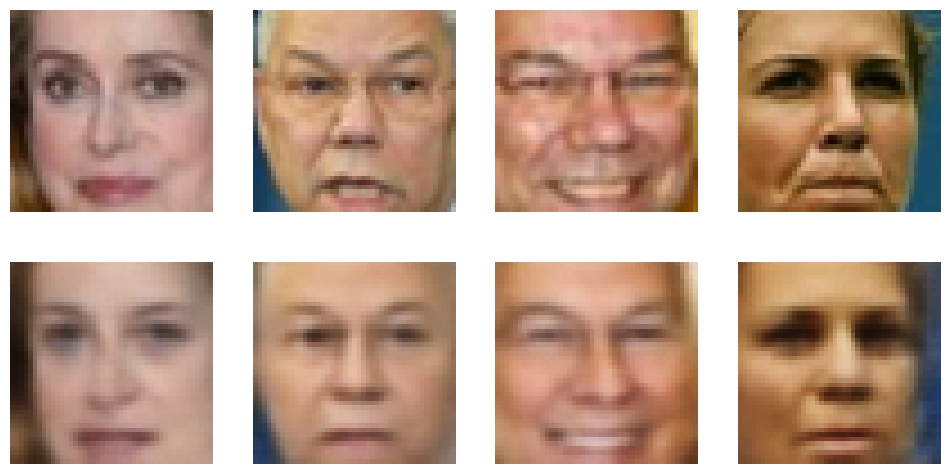

Epoch 12/30 | Train Loss: 0.0028 | Val Loss: 0.0040


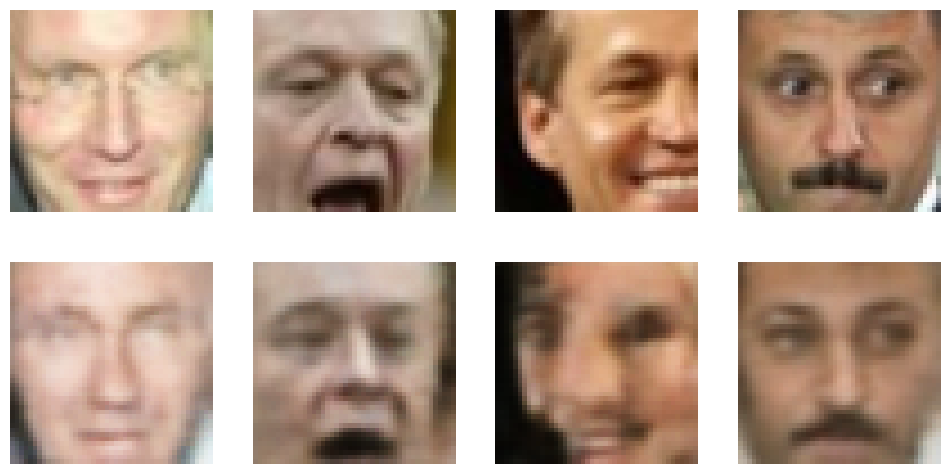

Epoch 13/30 | Train Loss: 0.0027 | Val Loss: 0.0038


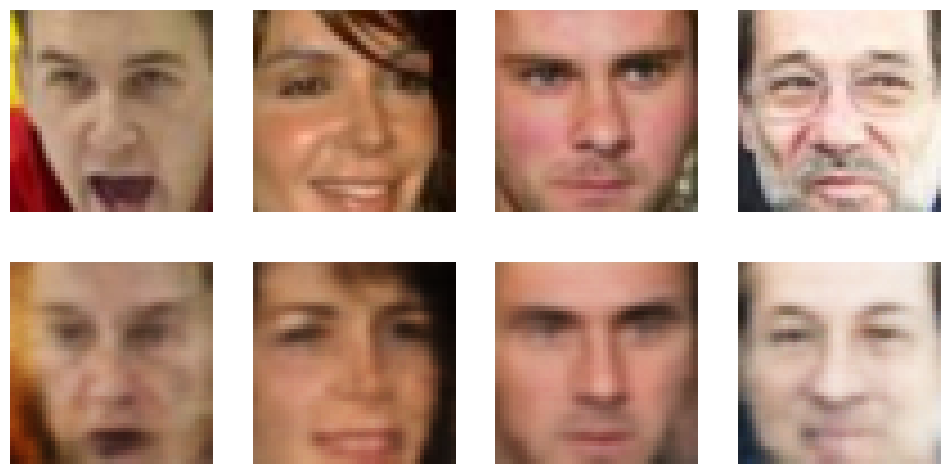

Epoch 14/30 | Train Loss: 0.0026 | Val Loss: 0.0038


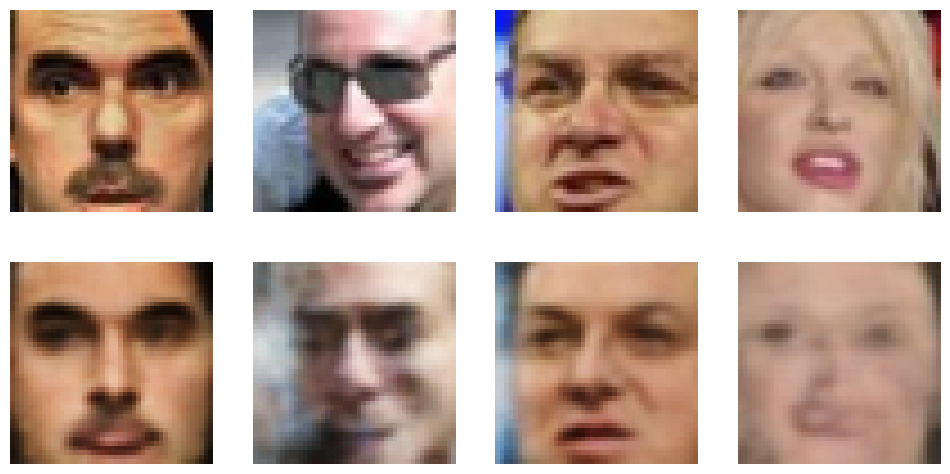

Epoch 15/30 | Train Loss: 0.0024 | Val Loss: 0.0038


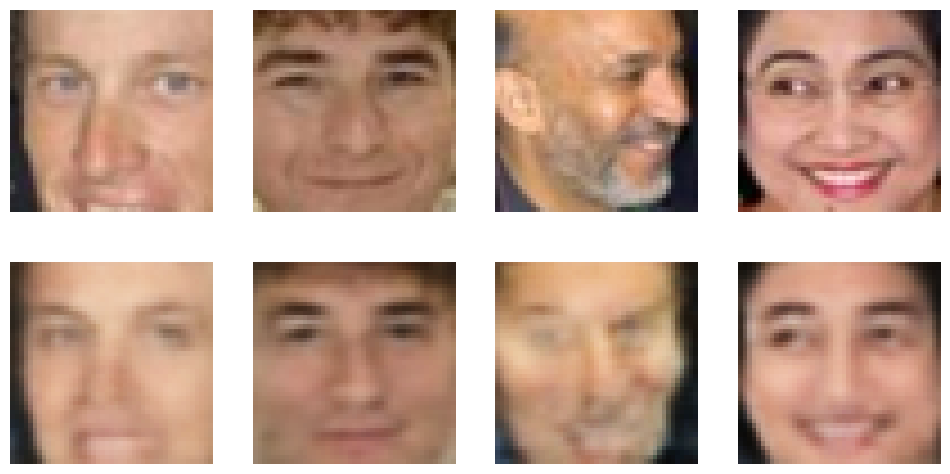

Epoch 16/30 | Train Loss: 0.0026 | Val Loss: 0.0039


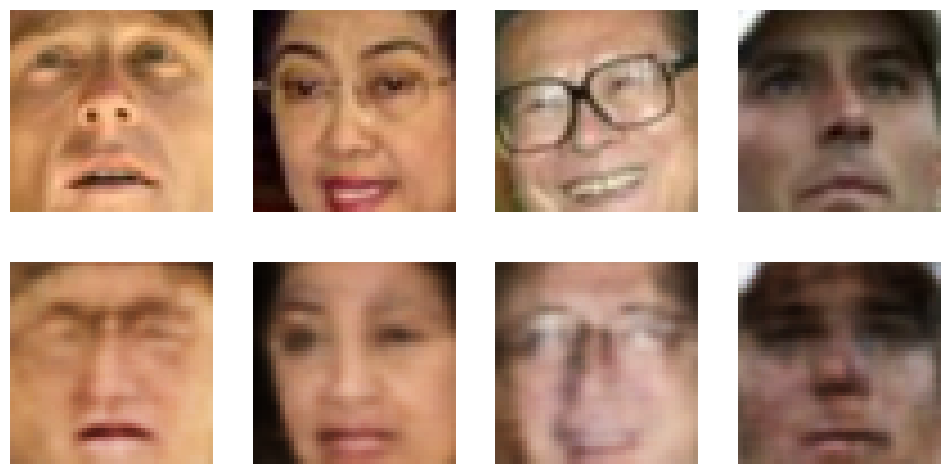

Epoch 17/30 | Train Loss: 0.0022 | Val Loss: 0.0036


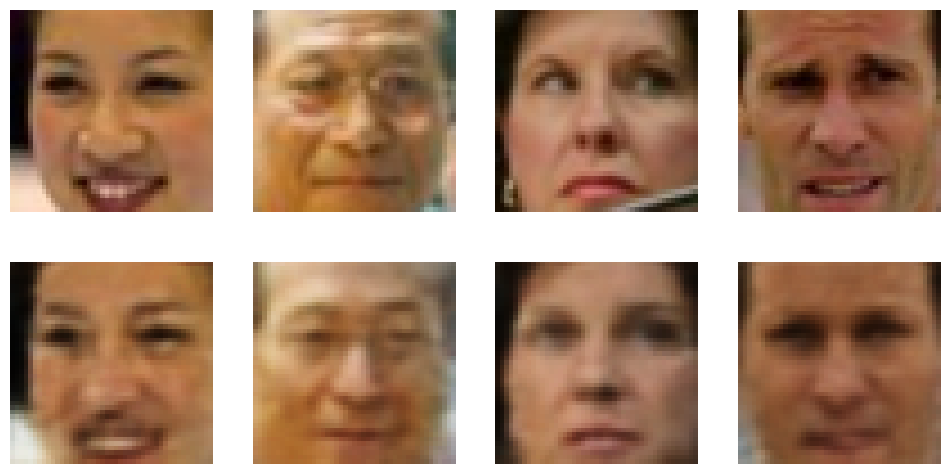

Epoch 18/30 | Train Loss: 0.0021 | Val Loss: 0.0036


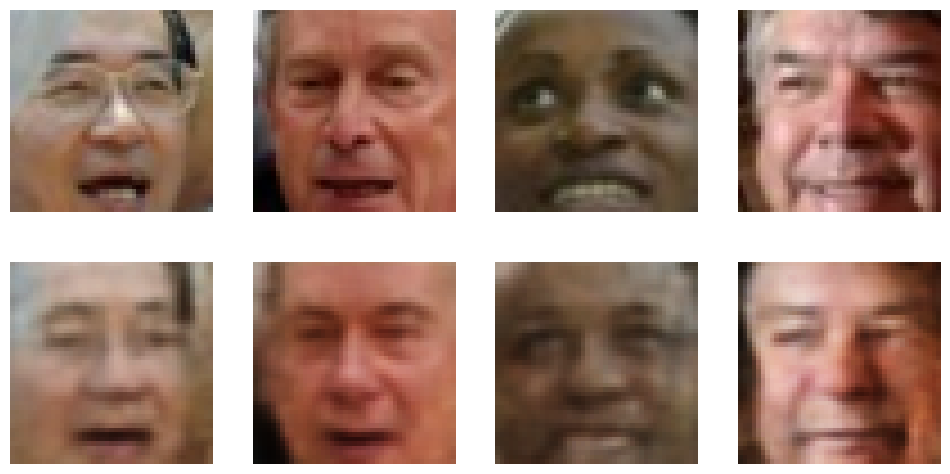

Epoch 19/30 | Train Loss: 0.0020 | Val Loss: 0.0036


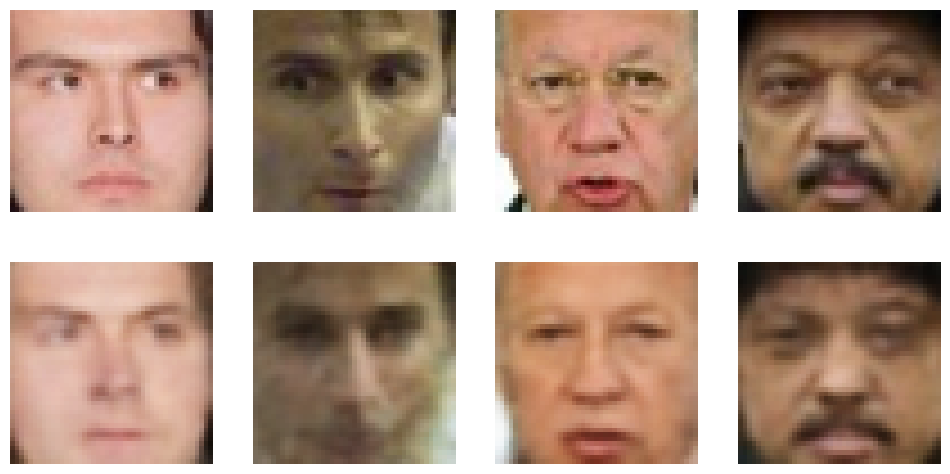

Epoch 20/30 | Train Loss: 0.0020 | Val Loss: 0.0036


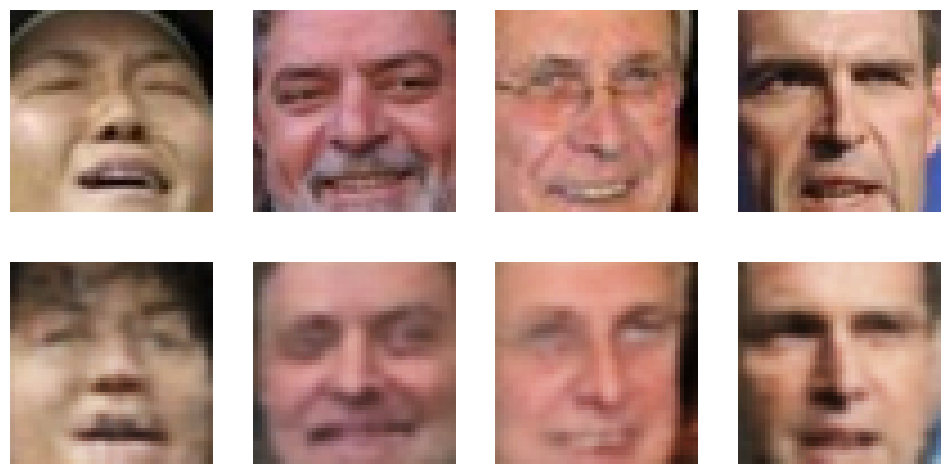

Epoch 21/30 | Train Loss: 0.0019 | Val Loss: 0.0038


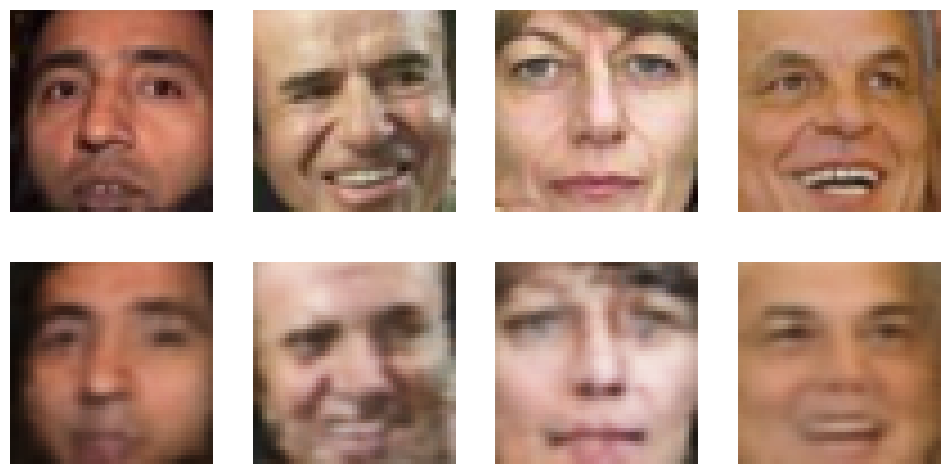

Epoch 22/30 | Train Loss: 0.0018 | Val Loss: 0.0036


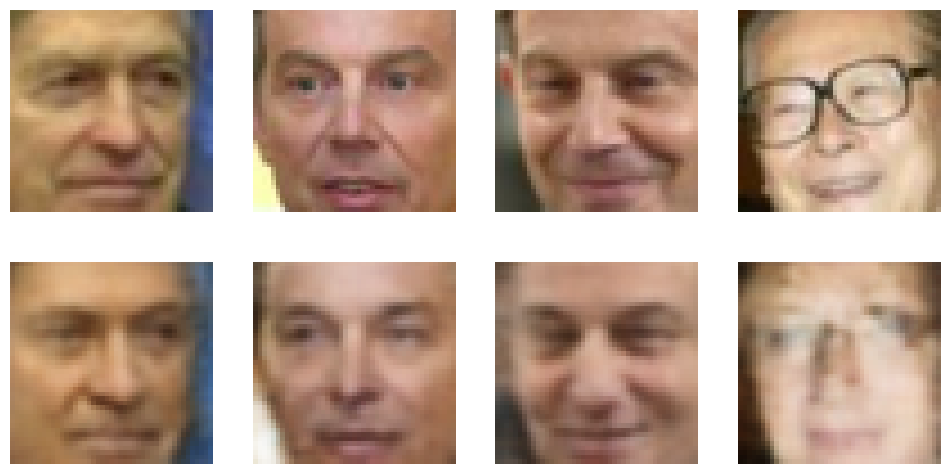

Epoch 23/30 | Train Loss: 0.0018 | Val Loss: 0.0036


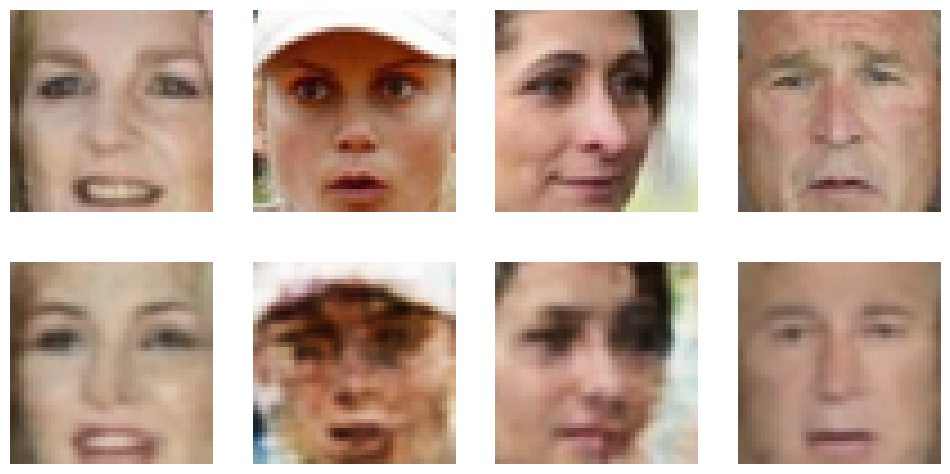

Epoch 24/30 | Train Loss: 0.0017 | Val Loss: 0.0036


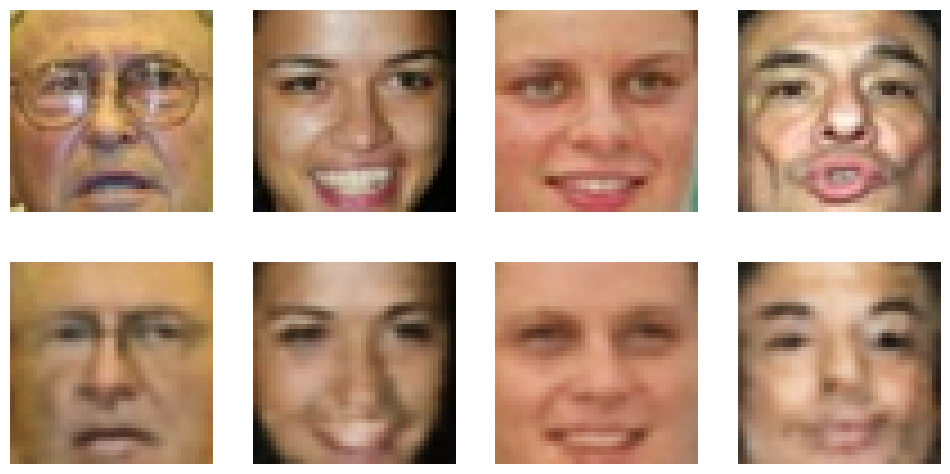

Epoch 25/30 | Train Loss: 0.0017 | Val Loss: 0.0035


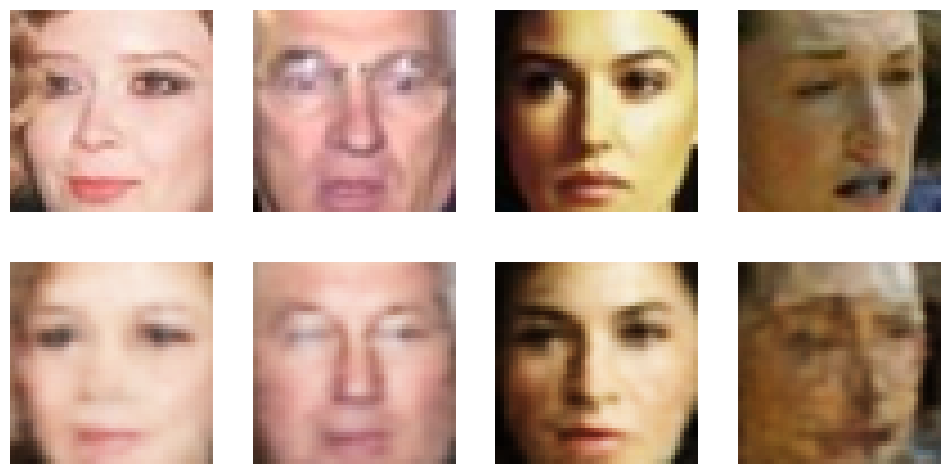

Epoch 26/30 | Train Loss: 0.0016 | Val Loss: 0.0035


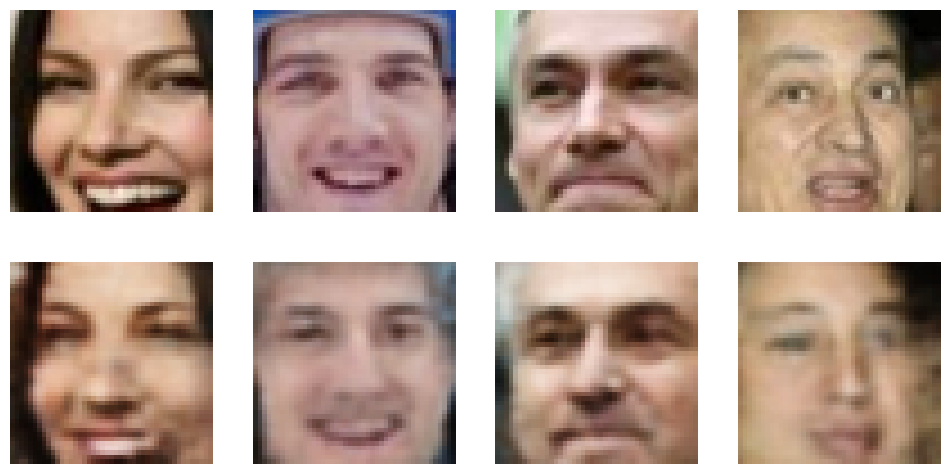

Epoch 27/30 | Train Loss: 0.0016 | Val Loss: 0.0036


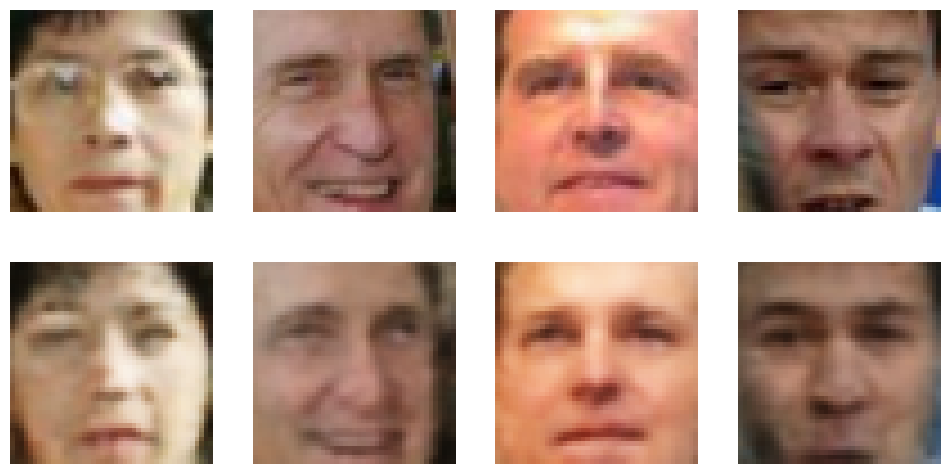

Epoch 28/30 | Train Loss: 0.0016 | Val Loss: 0.0036


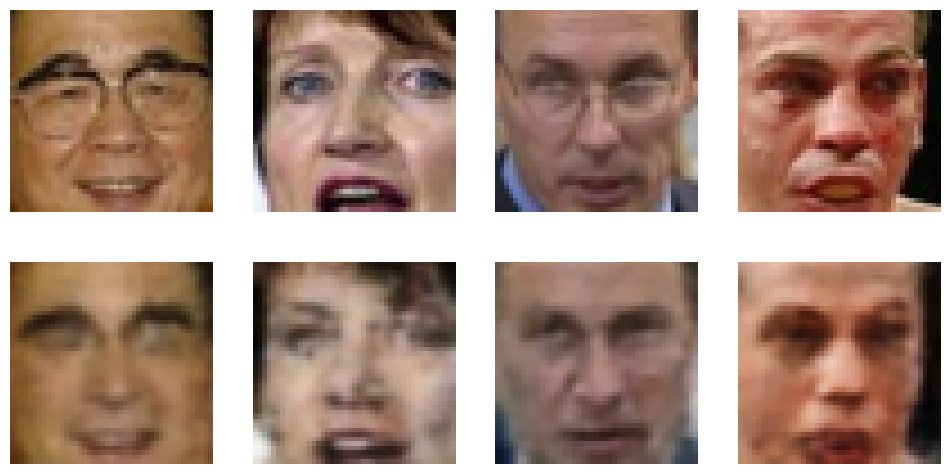

Epoch 29/30 | Train Loss: 0.0015 | Val Loss: 0.0036


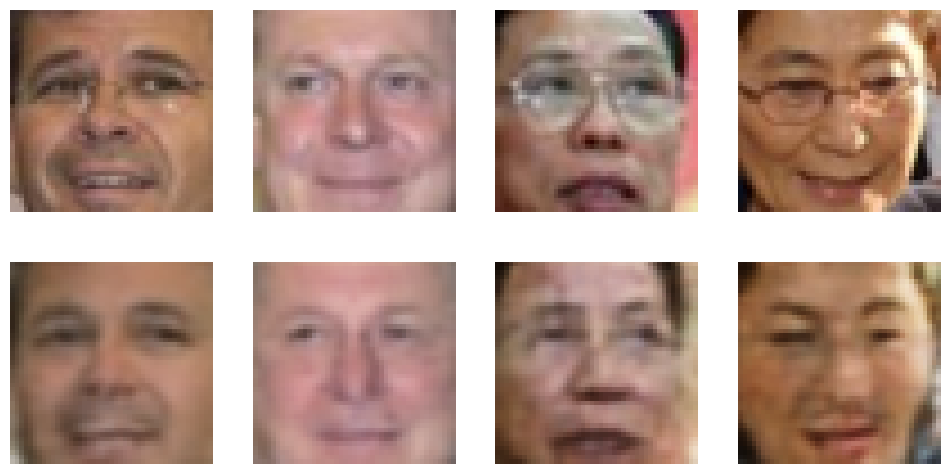

Epoch 30/30 | Train Loss: 0.0015 | Val Loss: 0.0036


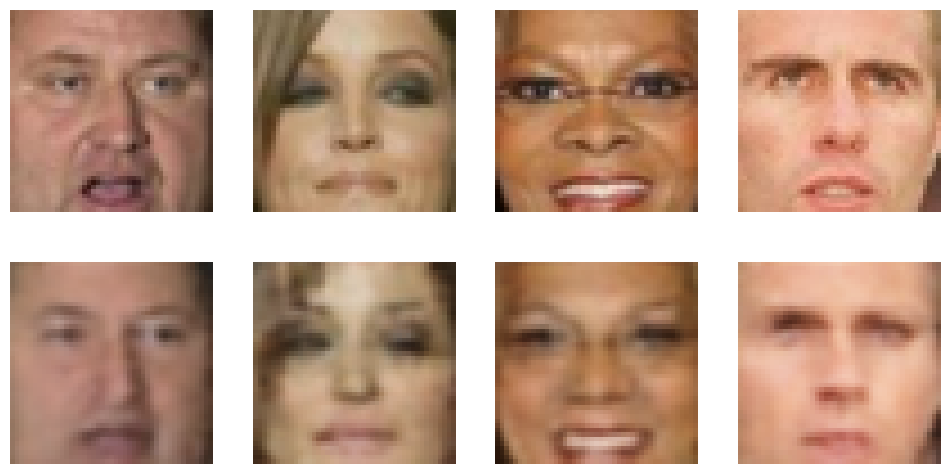

In [47]:
n_epochs = 30
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model = Autoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = F.mse_loss
train_losses = []
val_losses = []

def show_reconstruction(model, val_loader, device, n=4):
    model.eval()
    with torch.no_grad():
        for X_batch in val_loader:
            imgs = X_batch[0].to(device)
            recon, _ = model(imgs)
            imgs = imgs.cpu().numpy()
            recon = recon.cpu().numpy()

            n = min(n, imgs.shape[0])

            fig, axs = plt.subplots(2, n, figsize=(3 * n, 6))
            for i in range(n):
                axs[0, i].imshow(imgs[i].transpose(1, 2, 0))  # оригинал
                axs[0, i].axis('off')
                axs[1, i].imshow(recon[i].transpose(1, 2, 0))  # реконструкция
                axs[1, i].axis('off')
            axs[0, 0].set_ylabel("Original")
            axs[1, 0].set_ylabel("Reconstructed")
            plt.show()
            break

for epoch in tqdm_notebook(range(n_epochs)):
    model.train()
    train_losses_per_epoch = []

    for i, X_batch in enumerate(train_loader):
        optimizer.zero_grad()
        reconstructed, _ = model(X_batch[0].to(device))
        loss = loss_fn(reconstructed, X_batch[0].to(device))
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in val_loader:
          reconstructed, _ = model(X_batch[0].to(device))
          loss = loss_fn(reconstructed, X_batch[0].to(device))
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))


    print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")
    show_reconstruction(model, val_loader, device, n=5)



Давайте посмотрим, как наш тренированный автоэнкодер кодирует и восстанавливает картинки:

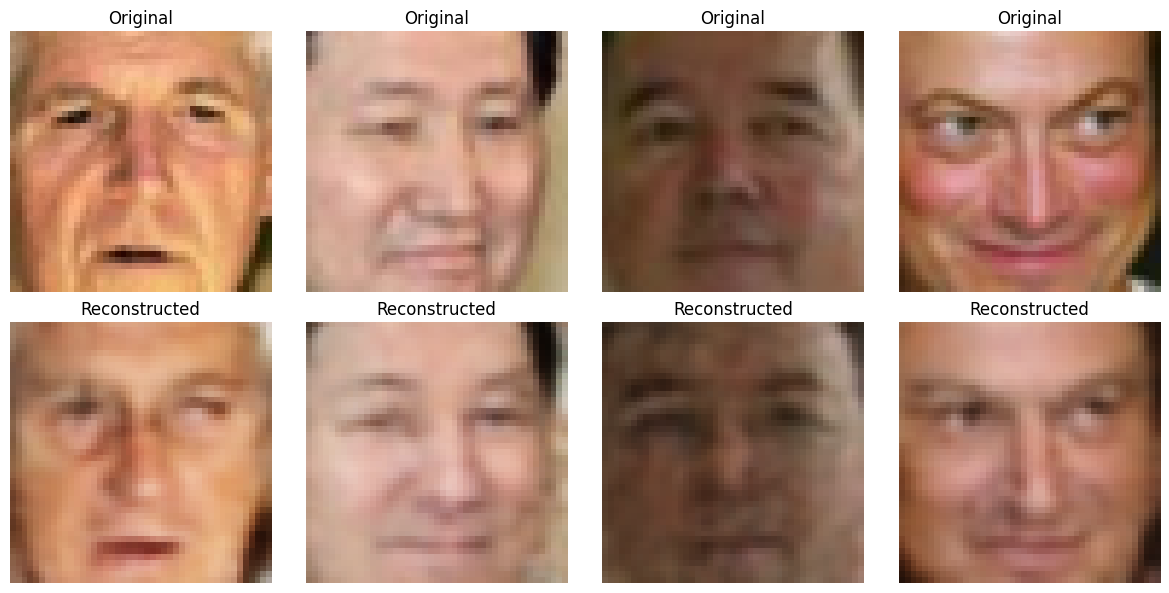

In [52]:
import matplotlib.pyplot as plt

def show_val_reconstructions(model, val_loader, device, X=4):
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            imgs = batch[0].to(device)
            recon, _ = model(imgs)

            imgs = imgs[:X].cpu().numpy()
            recon = recon[:X].cpu().numpy()

            fig, axs = plt.subplots(2, X, figsize=(3 * X, 6))

            for i in range(X):
                axs[0, i].imshow(imgs[i].transpose(1, 2, 0))
                axs[0, i].axis('off')
                axs[0, i].set_title("Original")

                axs[1, i].imshow(recon[i].transpose(1, 2, 0))
                axs[1, i].axis('off')
                axs[1, i].set_title("Reconstructed")

            plt.tight_layout()
            plt.show()
            break

show_val_reconstructions(model, val_loader, device, X=4)

Что вы можете сказать про результат?

Реконструкция проходит неплохо, loss не сильно большой, но картинка плохого качества и не совсем соответствует оригиналу

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэнкодер и получать реконструкцию, а попробуем создать что-то НОВОЕ!

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__ Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

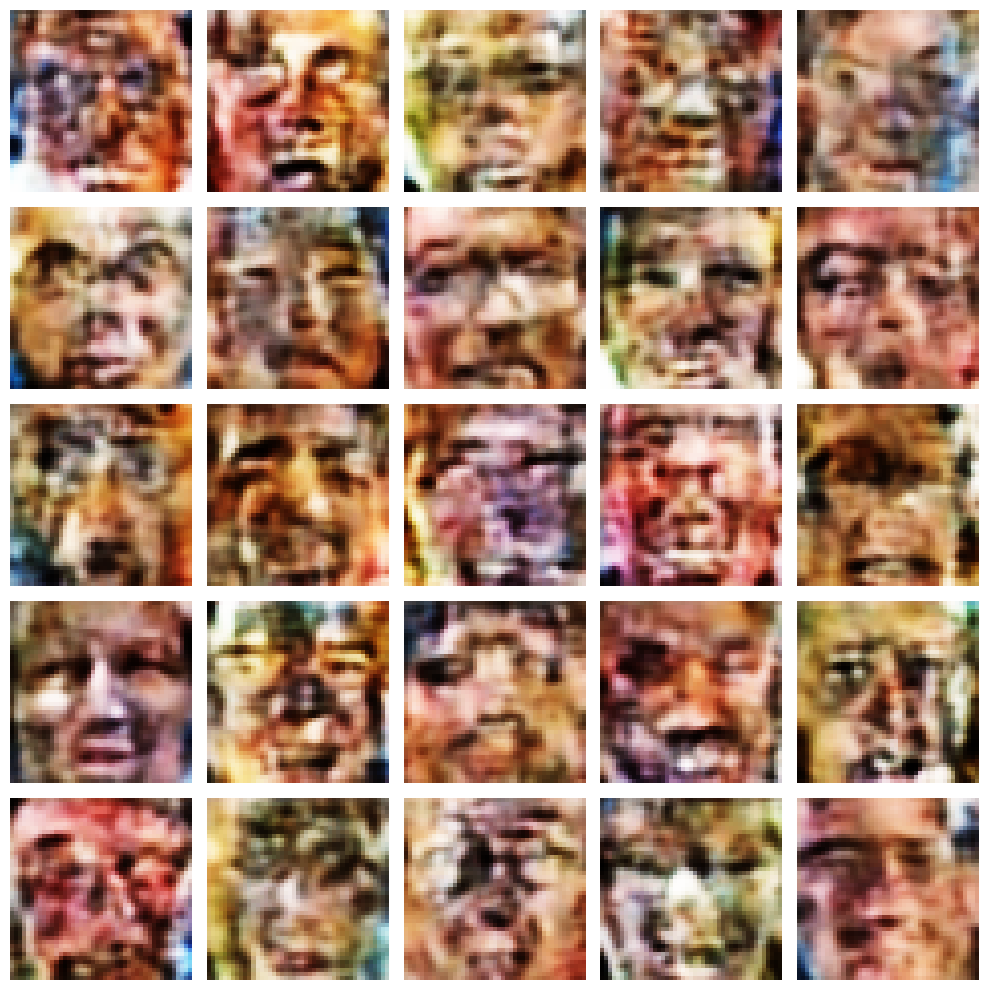

In [58]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(25, dim_code).astype(np.float32)
z = torch.tensor(z).to(device)

def show_random(model, device, dim_code, n=5):
    model.eval()
    with torch.no_grad():

            # Используем decoder для данных
            generated = model.decoder(z)
            # Подгоняем данные под нужный формат
            generated = generated[:, :, :45, :45]

            generated = generated.cpu().numpy()

            fig, axs = plt.subplots(n, n, figsize=(2 * n, 2 * n))

            for i in range(n*n):
                ax = axs[i // n, i % n]
                ax.imshow(generated[i].transpose(1, 2, 0))
                ax.axis("off")
            plt.tight_layout()
            plt.show()

show_random(model, device, dim_code=128, n=5)

Для того, чтобы получить более приемлемый результат, посмтрим распределение реальных данных

In [61]:
z_real = []
model.eval()
with torch.no_grad():
    for batch in val_loader:
        _, z = model(batch[0].to(device))
        z_real.append(z.cpu())
        if len(z_real) > 10:  # достаточно 10 батчей
            break
z_real = torch.cat(z_real, dim=0).numpy()

mean = z_real.mean(axis=0)
std = z_real.std(axis=0)
print(f"mean: {mean}\nstd: {std}")

mean: [-0.14986165 -0.04836847  0.07994621  0.30876982  0.0293928  -0.04826243
  0.07243437  0.07287499 -0.01752536 -0.00845129  0.06237645  0.06152118
  0.03080255 -0.18453938 -0.05290725  0.03793518 -0.05153161  0.14468184
 -0.06867963  0.17908965  0.01556467 -0.19374304 -0.06263314  0.11759264
 -0.19913216  0.10460009  0.03235213 -0.17559543 -0.07523385  0.13064711
 -0.11678901  0.575771    0.32797667  0.23151852 -0.2961549   0.0632623
 -0.03913512 -0.05073715  0.0414254   0.06413209 -0.04851181 -0.03702639
  0.04178331 -0.23232435  0.11797853  0.0405732   0.0419696  -0.0108225
  0.12598489  0.03914277  0.03092881  0.09814849  0.10587751  0.07893772
  0.14216512  0.04314549  0.12636432  0.37872055  0.19093055  0.05204508
  0.05830117 -0.00378242  0.05958631 -0.02306305  0.11596698  0.05356595
 -0.03094888 -0.08446284 -0.05124763  0.03044775 -0.09110191  0.12626676
  0.04329892  0.16937879  0.3018538  -0.05276112 -0.11283778  0.03488583
  0.16697352  0.11523338  0.00546826 -0.0585497

Теперь же сделаем поэлементное маштабирование и сдвиг, то есть нормализуем данные с учетом std и mean тестовой выборки

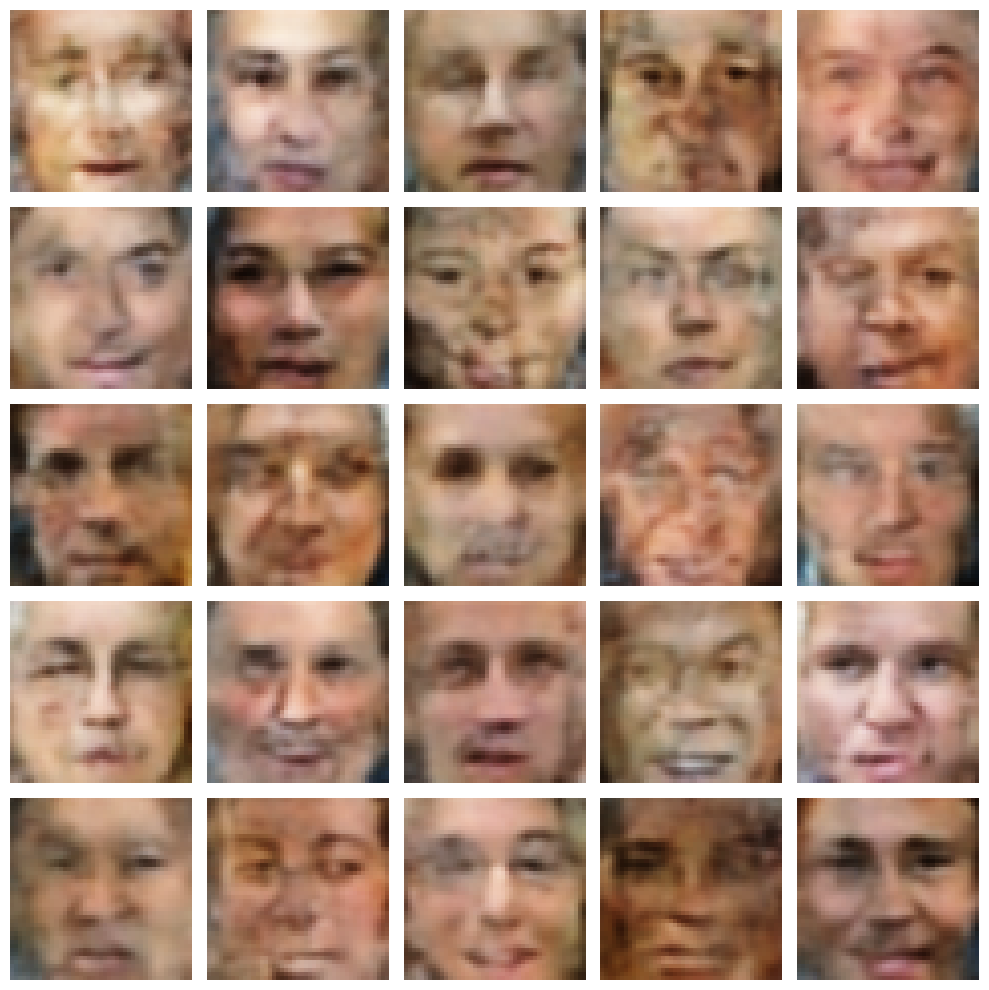

In [62]:
z = (np.random.randn(25, dim_code) * std + mean).astype(np.float32)
z = torch.tensor(z).to(device)

show_random(model, device, dim_code=128, n=5)

В данном случае получаем картинки, уже больше похожие на лица людей

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с атрибутами, скачанный вместе с картинками. В нем указаны имена изображений и присутствубщие атрибуты (улыбки, очки и прочее интересное).

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких.

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей.

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [72]:
# Посмотрим как выглядит attrs
print(attrs.head())
print(attrs.columns)

       Male     Asian     White     Black      Baby     Child     Youth  \
0  1.568346 -1.889043  1.737203 -0.929729 -1.471799  -0.19558 -0.835609   
1  0.169851 -0.982408  0.422709 -1.282184  -1.36006 -0.867002 -0.452293   
2  0.997749 -1.364195 -0.157377 -0.756447 -1.891825 -0.871526 -0.862893   
3  1.122719 -1.997799  1.916144 -2.514214 -2.580071 -1.404239  0.057551   
4  1.078214 -2.008098  1.676211 -2.278056 -2.651845 -1.348408  0.649089   

  Middle Aged    Senior Black Hair  ... Pale Skin 5 o' Clock Shadow  \
0   -0.351468 -1.012533  -0.719593  ...  0.361738          1.166118   
1   -0.197521 -0.956073  -0.802107  ... -0.832036          -0.39768   
2    0.031445 -1.341523  -0.090037  ...  1.549743          1.884745   
3    0.000196 -1.273512  -1.431462  ...  0.567822         -0.176089   
4    0.017656 -1.889111  -1.857213  ... -1.461474         -0.955283   

  Strong Nose-Mouth Lines Wearing Lipstick Flushed Face High Cheekbones  \
0               -1.164916         -1.13999    -

Видим колонки, которые нам понадобятся:

- 'Smiling'

- 'Frowning'

In [80]:
smile_mask = y_val[:, smiling_idx] > 0 # True - улыбка
frown_mask = y_val[:, smiling_idx] < 0 # True - грусть

smile_indices = torch.where(smile_mask)[0][:15] # Берём первые 15 индексов с улыбкой
frown_indices = torch.where(frown_mask)[0][:15] # Берём первые 15 индексов без улыбки

# Берем изображения по индексам
smile_imgs = x_val[smile_indices].to(device)
frown_imgs = x_val[frown_indices].to(device)

In [81]:

# получаем только латентные коды, игнорируем реконструкции
model.eval()
with torch.no_grad():
    _, z_smile = model(smile_imgs)
    _, z_frown = model(frown_imgs)

# Средние латентные векторы для улыбающихся и грустных
z_smile_mean = z_smile.mean(dim=0)
z_frown_mean = z_frown.mean(dim=0)
# Разность - вектор улыбки
smile_vector = z_smile_mean - z_frown_mean

In [82]:
img_frown = frown_imgs[0].unsqueeze(0)
with torch.no_grad():
    _, z_frown_single = model(img_frown)
    z_with_smile = z_frown_single + smile_vector.unsqueeze(0) # добавляем улыбку
    smiled_img = model.decoder(z_with_smile)
    smiled_img = smiled_img[:, :, :45, :45]  # если есть обрезка


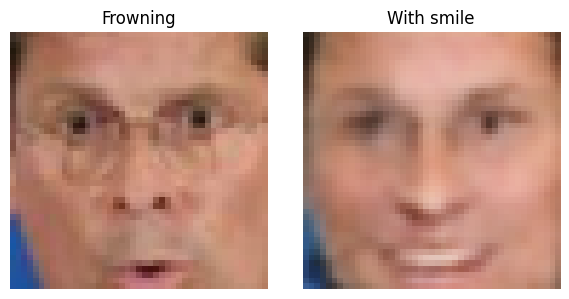

In [83]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(img_frown.squeeze().cpu().permute(1, 2, 0).numpy())
axs[0].set_title("Frowning")
axs[0].axis("off")

axs[1].imshow(smiled_img.squeeze().cpu().permute(1, 2, 0).numpy())
axs[1].set_title("With smile")
axs[1].axis("off")

plt.tight_layout()
plt.show()


Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... В общем, все, на что хватит фантазии и на что есть атрибуты в `attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [9]:
from torchvision import transforms
from torchvision.transforms import ToTensor

In [21]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [34]:
print(images.shape)

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])


In [35]:
features = 16
class VAE(nn.Module):
    def __init__(self):
        #<определите архитектуры encoder и decoder
        #помните, у encoder должны быть два "хвоста",
        #т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        super().__init__()

        self.flatten = nn.Flatten()

        self.encoder = nn.Sequential(
            nn.Linear(in_features=784, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=features*2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=features, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=784)
        )

    def encode(self, x):
        #<реализуйте forward проход энкодера
        #в качестве ваозвращаемых переменных -- mu и logsigma>
        x = self.flatten(x).float()
        x = self.encoder(x).view(-1, 2, features)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            #<засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            return mu + (eps * std)
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z):
        #<реализуйте forward проход декодера
        #в качестве возвращаемой переменной -- reconstruction>
        x = self.decoder(z)
        reconstruction = torch.sigmoid(x)
        return reconstruction

    def forward(self, x):
        #<используя encode и decode, реализуйте forward проход автоэнкодера
        #в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [36]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [37]:
#device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
criterion = loss_vae

autoencoder = VAE()

optimizer = torch.optim.Adam(autoencoder.parameters())

Обучим модель

In [44]:
n_epochs = 40
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch in train_loader:
        optimizer.zero_grad()
        images = batch[0].to(device)
        mu, logsigma, reconstruction = autoencoder(images)
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        loss = criterion(images.float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in test_loader:
          images = batch[0].to(device)
          mu, logsigma, reconstruction = autoencoder(images)
          reconstruction = reconstruction.view(-1, 1, 28, 28)
          loss = criterion(images.float(), mu, logsigma, reconstruction)
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

  0%|          | 0/40 [00:00<?, ?it/s]

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [48]:
  autoencoder.eval()
  with torch.no_grad():
      for batch in test_loader:
        images = batch[0].to(device)
        mu, logsigma, reconstruction = autoencoder(images)
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        result = reconstruction.cpu().detach().numpy()
        ground_truth = batch[0].cpu().numpy()
        break

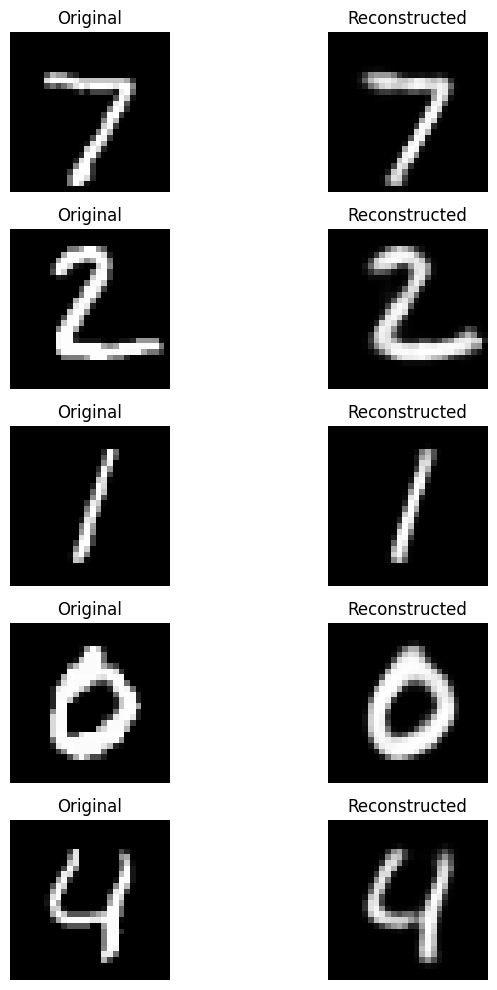

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 10))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(gt.squeeze(), cmap='gray')  # оригинал
    plt.title("Original")
    plt.axis('off')

    plt.subplot(5, 2, 2*i+2)
    plt.imshow(res.squeeze(), cmap='gray')  # реконструкция
    plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.show()


Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, 100) for i in range(10)])
output = <скормите z декодеру>
<выведите тут полученные картинки>

z = np.random.randn(25, dim_code).astype(np.float32)
z = torch.tensor(z).to(device)

z_real = []
model.eval()
with torch.no_grad():
    for batch in val_loader:
        _, z = model(batch[0].to(device))
        z_real.append(z.cpu())
        if len(z_real) > 10:  # достаточно 10 батчей
            break
z_real = torch.cat(z_real, dim=0).numpy()

mean = z_real.mean(axis=0)
std = z_real.std(axis=0)
print(f"mean: {mean}\nstd: {std}")

z = (np.random.randn(25, dim_code) * std + mean).astype(np.float32)
z = torch.tensor(z).to(device)

show_random(model, device, dim_code=128, n=5)

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
<ваш код получения латентных представлений, применения TSNE и визуализации>

Что вы думаете о виде латентного представления?

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
class CVAE(nn.Module):
    def __init__(self):
        # <определите архитектуры encoder и decoder
        # помните, у encoder должны быть два "хвоста",
        # т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>

    def encode(self, x, class_num):
        # <реализуйте forward проход энкодера
        # в качестве возвращаемых переменных -- mu, logsigma и класс картинки>

        return mu, logsigma, class_num

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            # засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z, class_num):
        # реализуйте forward проход декодера
        # в качестве возвращаемой переменной -- reconstruction

        return reconstruction

    def forward(self, x):
        # используя encode и decode, реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction
        return mu, logsigma, reconstruction

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [ ]:
<тут нужно научиться сэмплировать из декодера цифры определенного класса>

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
<ваш код получения латентных представлений, применения TSNE и визуализации>

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

# BONUS 1: Denoising (2 балла)

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума.
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом.

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудьте разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает шум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval (2 балла)

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентных представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>

  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат

    distances,neighbors = get_similar(image,n_neighbors=11)

    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")

    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>